# Markov-1

In 2D flow, assuming isotropic RMS velocity ($\nu$), the Markov-1 model can be formulated as follows:
$$
dx_i = [U_i(\mathbf{x}) + u'_i]dt \\
du'_i = -\frac{1}{T_L} u'_i dt + \sqrt{\frac{2}{T_L}}\nu dW_i
$$

This is easily integrated in time. Note that in the limit $t>>T_l$, the dispersion can be approximated as diffusive $\kappa = \nu^2 T_l$.

In 3D, without assuming isotropy, the Markov-1 parameterization becomes more involved:
$$
dx_i = [U_i(\mathbf{x}) + u'_i]dt \\
du'_i = [-\theta^{-1}(\mathbf{x})_{ij}u'_j + \tilde{a}_i(\mathbf{x, u'})] dt + b_{ij}(\mathbf{x}) dW_j(t)
$$

Here, $\theta$ is fading-memory time tensor, and $\tilde{a}_i$ is a drift correction term for asserting the well-mixed condition (similar to 'kicking particles out of low diffusivity areas' in the diffusive model). It's given by 

$$
\tilde{a}_i = \frac{1}{2} \frac{\partial \sigma_{ik}}{\partial x_k} - \frac{\sigma_{im}}{2}(U_k+u'_k)\frac{\partial(\sigma^{-1})_{jm}}{\partial x_k} u'j
$$

The stochastic increment is related to $\sigma$, the velocity RMS tensor, as 
$$ b_{ij}b_{jk} = 2\sigma_{ij}(\theta^{-1})_{jk}$$.

In isopycnal coordinates, we can assume that $\sigma$ and $\theta$ are isotropic in the isopycnal plane, with values on the diagonal of $\nu^2$ and $T_l$ respectively, except for on the $zz$-elements, where these values are multiplied by small parameters $\eta$ and $\varepsilon$ respectively. These tensors can be rotated into geodesic coordinates in a similar way as described by Redi (1982).

This notebook investigates the behavior of the Markov-1 model in an idealized set-up, similar to that of Shah et al. (2011) and Van Sebille et al. (2018), and compares it to that of the Markov-0 (diffusive) model.

In [1]:
import math
import random
import numpy as np
import xarray as xr

from datetime import timedelta
import sys
import warnings

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter, NullFormatter

import plotly
import plotly.graph_objects as go

import parcels
from parcels import (
    AdvectionDiffusionEM,
    AdvectionRK4_3D,
    AdvectionDiffusionM1,
    DiffusionUniformKh,
    FieldSet,
    JITParticle,
    ScipyParticle,
    ParticleSet,
    Variable,
    ParcelsRandom,
)
import importlib
import pickle
import pandas as pd
from scipy.integrate import dblquad

INFO: Compiled ParcelsRandom ==> /tmp/parcels-23300/libparcels_random_19f8cb21-4378-4a01-9803-30bcc5466802.so


In [2]:
sys.path.append("/Users/4302001/surfdrive/diffusion-hydro-mod/kernels")
sys.path.append("/nethome/4302001/diffusion-hydro-mod/kernels")
import idealized_isopycnal_field
import elements_analytical
import K_Le_Sommer
import K_Redi
import K_Redi_smallslope
import EM_3D_BC
import M1_3D_BC
import idealized_isopycnal_field
import Markov1_3D_BC_taper
import Markov1_3D_BC_taper_init
importlib.reload(idealized_isopycnal_field)

<module 'idealized_isopycnal_field' from '/science-nfs-sys/vsm01/users/4302001/diffusion-hydro-mod/idealized_experiments/idealized_isopycnal_field.py'>

# Set-up

In [3]:
def create_analytical_fieldset(
    rhoField,
    Ki=1000,
    Tl=1 * 24 * 60 * 60,
    nu_squared=None,  # RMS eddy velocity, following Koszalka
    epsilon=None,
    eta=None,
    expansion_terms=None,
):
    """
    Prepares a fieldset of an idealized isopycnal field.

    The fieldset can be used for numerically computing trajectories using Markov-1 or Markov-0 (diffusive) parameterizations. 
    Note that in case of Markov-1, `nu_squared` is computed using the assymptotic behavior: Ki = nu_squared * Tl,
    so only `Ki` and `Tl` need to be specified. 
    """
    
    data = {
        "U": np.zeros(1),
        "V": np.zeros(1),
        "W": np.zeros(1),
        "boundaryMask": np.ones(1),
    }
    
    dims = {"lon": 1, "lat": 1, "depth": 1}

    fieldset = parcels.FieldSet.from_data(
        data,
        dims,
        mesh="flat",
        allow_time_extrapolation=True,
    )

    # For analytical solution
    fieldset.add_constant("gval", rhoField.g)
    fieldset.add_constant("Nsquaredval", rhoField.Nsquared)
    fieldset.add_constant("alphaxval", rhoField.alphax)
    fieldset.add_constant("alphayval", rhoField.alphay)
    fieldset.add_constant("kappaxval", rhoField.kappax)
    fieldset.add_constant("kappayval", rhoField.kappay)
    fieldset.add_constant("rho0val", rhoField.rho0)

    # For Milstein
    if expansion_terms:
        fieldset.add_constant("expansion_terms", expansion_terms)

    # For Markov-0
    fieldset.add_constant("kappaval", Ki)

    # For Markov-1
    fieldset.add_constant("TL", Tl)  # Lagrangian timescale
    if Ki:
        fieldset.add_constant("nusquared", Ki / Tl)
    else:
        fieldset.add_constant("nusquared", nu_squared)

    if epsilon:
        fieldset.add_constant("epsilon", epsilon)
    else:
        fieldset.add_constant("epsilon", 0)
        
    if eta:
        fieldset.add_constant("etaval", eta)

    return fieldset

In [4]:
class Markov1Particle(parcels.JITParticle):
    u_prime = parcels.Variable('u_prime', initial=0)
    v_prime = parcels.Variable('v_prime', initial=0)
    w_prime = parcels.Variable('w_prime', initial=0)

In [5]:
def get_test_particles(
    rhoField, fieldset, rho=1027.5, nx=25, ny=50, xbounds=(250000, 750000), ybounds=(250000, 1750000), pclass=Markov1Particle
):
    XX, YY = np.meshgrid(
        np.linspace(xbounds[0], xbounds[1], nx), np.linspace(ybounds[0], ybounds[1], ny), indexing='ij'
    )
    lons = XX.flatten()
    lats = YY.flatten()
    depth = rhoField.isopycnal_array(lons, lats, rho_iso=rho)
    pset = parcels.ParticleSet.from_list(
        fieldset,
        pclass=pclass,
        lon=lons,
        lat=lats,
        depth=depth,
        time=np.zeros(nx * ny),
        lonlatdepth_dtype=np.float64,
    )

    return pset

In [6]:
def get_test_particles_dense(
    rhoField, fieldset, rho=1027.5, nx=80, ny=160, xbounds=(0, 1_000_000), ybounds=(0, 2_000_000), pclass=Markov1Particle
):
    """Get a set of evenly spaced testparticles, specified within xbounds and ybounds"""
    
    x_shift = (xbounds[1]-xbounds[0])/nx/2
    y_shift = (ybounds[1]-ybounds[0])/ny/2
    
    if x_shift != y_shift:
        warnings.warn('dx and dy not the same')
    
    XX, YY = np.meshgrid(
        np.linspace(xbounds[0] + x_shift, xbounds[1] - x_shift, nx), np.linspace(ybounds[0] + y_shift, ybounds[1] - y_shift, ny), indexing='ij'
    )
    lons = XX.flatten()
    lats = YY.flatten()
    depth = rhoField.isopycnal_array(lons, lats, rho_iso=rho)
    pset = parcels.ParticleSet.from_list(
        fieldset,
        pclass=pclass,
        lon=lons,
        lat=lats,
        depth=depth,
        time=np.zeros(nx * ny),
        lonlatdepth_dtype=np.float64,
    )

    return pset

In [7]:
def rms_z_error(x, y, z, rho=1027.5):
    """Determines the error (average distance from the isopycnal)"""
    
    true = myField.isopycnal_array(x, y, rho)
    rms_error = np.sqrt(np.mean((z - true)**2))
    return rms_error

In [8]:
def diapycnal_flux(x, y, z, t, rho=1027.5, tmode="seconds"):
    """Determines the diapycnal flux over time"""
    
    rms_error = rms_z_error(x, y, z, rho)
    
    if tmode == "hours":
        multip = 60 * 60
    elif tmode == "seconds":
        multip = 1
    return 0.5 * rms_error**2 / (multip * t)

In [9]:
def plotTestParticles(testParticles):
    fig = go.Figure(data=[go.Surface(x=XX/1000, y=YY/1000, z=ZZ_iso1027, opacity=0.4),
                          go.Scatter3d(x=(testParticles.lon % 1_000_000)/1000, y=(testParticles.lat % 2_000_000)/1000, z=testParticles.depth,
                                       mode='markers', marker=dict(size=1, color='blue'), opacity=0.8)])
    fig.update_layout(
        title="Isopycnal",
        autosize=False,
        width=1200,
        height=600,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            aspectratio=dict(x=1, y=2, z=0.5),
            xaxis=dict(title="x [km]"),
            yaxis=dict(title="y [km]"),
            zaxis=dict(title="z [m]", nticks=3),
        ),
    )

    fig.show()

## Kernels

In [10]:
def deleteParticle(particle, fieldset, time):
    particle.delete()

In [11]:
def periodic_BC(particle, fieldset, time):
    if particle.lon > 1_000_000:
        particle.lon -= 1_000_000
    elif particle.lon < 0:
        particle.lon += 1_000_000
    if particle.lat > 2_000_000:
        particle.lat -= 2_000_000
    elif particle.lat < 0:
        particle.lat += 2_000_000

## Create fields

In [12]:
myField = idealized_isopycnal_field.densityField()
myField.create_interpolated_density_grid(nx=201, ny=401, nz=901, H=6000)

In [13]:
ZZ_iso1027, XX, YY = myField.isopycnal_grid(1027.5, myField.X, myField.Y)

In [14]:
fieldset = create_analytical_fieldset(myField, Ki=1000)

In [15]:
def add_dummy_settings(fieldset):
    fieldset.add_constant("upperBound", 1e9)
    fieldset.add_constant("lowerBound", -1e9)
    fieldset.add_constant("northBound", 1e9)
    fieldset.add_constant("southBound", -1e9)
    # With our choice of $\alpha$, which sets the slope of the idealized neutral surface, these 
    # settings for the tapering parameter will effectively turn off tapering. This allows us to 
    # use the same kernel as used in the ACC simulations, which expects tapering parameters
    # to be specified.
    fieldset.add_constant("Sc", 1) 
    fieldset.add_constant("Sd", 0.001)

## Analytical Diffusion (Markov-0) Kernel
#### Full Redi + EM

In [140]:
fieldset = create_analytical_fieldset(myField, epsilon=1e-7)
add_dummy_settings(fieldset)
testParticles = get_test_particles_dense(myField, fieldset, rho=1027.5)
ParcelsRandom.seed(1636)
testParticles.execute(
            testParticles.Kernel(elements_analytical.elements_analytical) 
            + testParticles.Kernel(K_Redi.K_Redi) 
            + testParticles.Kernel(EM_3D_BC.EM_3D_BC),
            runtime=timedelta(hours=90 * 24),
            dt=timedelta(minutes=40),
            verbose_progress=True,
)
diapycnal_flux(testParticles.lon, testParticles.lat, testParticles.depth, 90*24*60*60)

INFO: Compiled Markov1Particleelements_analyticalK_RediEM_3D_BC ==> /tmp/parcels-23300/821b4d76dfd789e265c23484f7360a27_0.so
100% (7776000.0 of 7776000.0) |##########| Elapsed Time: 0:00:37 Time:  0:00:37


0.0001017728447063622

In [139]:
fieldset = create_analytical_fieldset(myField, epsilon=0)
add_dummy_settings(fieldset)
testParticles = get_test_particles_dense(myField, fieldset, rho=1027.5)
ParcelsRandom.seed(1636)
testParticles.execute(
            testParticles.Kernel(elements_analytical.elements_analytical) 
            + testParticles.Kernel(K_Redi.K_Redi) 
            + testParticles.Kernel(EM_3D_BC.EM_3D_BC),
            runtime=timedelta(hours=90 * 24),
            dt=timedelta(minutes=40),
            verbose_progress=True,
)
diapycnal_flux(testParticles.lon, testParticles.lat, testParticles.depth, 90*24*60*60)

INFO: Compiled Markov1Particleelements_analyticalK_RediEM_3D_BC ==> /tmp/parcels-23300/6ad91ce4d5297faadcff62cf2261296c_0.so
100% (7776000.0 of 7776000.0) |##########| Elapsed Time: 0:00:39 Time:  0:00:39


4.343449468817186e-06

#### Full Redi + Milstein

In [129]:
fieldset = create_analytical_fieldset(myField, Ki=1000, epsilon=1e-13)
add_dummy_settings(fieldset)
fieldset.add_constant("expansion_terms", 6)
testParticles = get_test_particles_dense(myField, fieldset)
ParcelsRandom.seed(1636)
testParticles.execute(
                    testParticles.Kernel(elements_analytical.elements_analytical) 
                        + K_Redi.K_Redi
                        + M1_3D_BC.M1_3D_BC,
                    runtime=timedelta(hours=90 * 24),
                    dt=timedelta(minutes=40),
                    verbose_progress=True,
#     recovery={parcels.ErrorCode.ErrorOutOfBounds: deleteParticle}
)
diapycnal_flux(testParticles.lon, testParticles.lat, testParticles.depth, 90*24*60*60)

INFO: Compiled Markov1Particleelements_analyticalK_RediM1_3D_BC ==> /tmp/parcels-23300/ce0459cb541f91f87375c830f7a4cf7b_0.so
100% (7776000.0 of 7776000.0) |##########| Elapsed Time: 0:02:55 Time:  0:02:55


7.666823690974786e-10

#### Small-slope + EM

In [36]:
fieldset = create_analytical_fieldset(myField, epsilon=0)
add_dummy_settings(fieldset)
testParticles = get_test_particles_dense(myField, fieldset, rho=1027.5)
ParcelsRandom.seed(1636)
testParticles.execute(
            testParticles.Kernel(elements_analytical.elements_analytical) 
            + testParticles.Kernel(K_Redi_smallslope.K_Redi_smallslope) 
            + testParticles.Kernel(EM_3D_BC.EM_3D_BC),
            runtime=timedelta(hours=90 * 24),
            dt=timedelta(minutes=40),
            verbose_progress=True,
)
diapycnal_flux(testParticles.lon, testParticles.lat, testParticles.depth, 90*24*60*60)

INFO: Compiled Markov1Particleelements_analyticalK_Redi_smallslopeEM_3D_BC ==> /tmp/parcels-23300/c0d3b82826c82bb7e1584a6c950a3469_0.so
100% (7776000.0 of 7776000.0) |##########| Elapsed Time: 0:00:25 Time:  0:00:25


4.343550737847064e-06

In [ ]:
fig = go.Figure(data=[go.Surface(x=XX, y=YY, z=ZZ_iso1027, opacity=0.4, showscale=False),
                      go.Scatter3d(x=testParticles.lon % 1_000_000, y=testParticles.lat % 2_000_000, z=testParticles.depth,
                                   mode='markers', marker=dict(size=0.5, color='blue'), opacity=0.7)])
fig.update_layout(
    #title="Isopycnal",
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=20, r=20, b=20, t=20),
    scene=dict(
        aspectratio=dict(x=1, y=2, z=0.5),
        xaxis=dict(title="x [m]"),
        yaxis=dict(title="y [m]"),
        zaxis=dict(title="z [m]", nticks=3),
    ),
    scene_camera = dict(
        eye=dict(x=1.25*1.8, y=-0.5*1.8, z=0.75*1.8)
    )
)
fig.write_image("viz/particles_EM_90days_k1000_dt40mins.png", width=800, height=500, scale=3)

In [154]:
def EM_error(dt_mins, Ki, powers=11, plot=True):
    runHours = np.ones(powers) * 2**np.arange(powers)
    z_error = np.zeros(powers)
    diaflux = np.zeros(powers)
    
    fieldset = create_analytical_fieldset(myField, Ki=Ki)
    add_dummy_settings(fieldset)

    for i, hours in enumerate(runHours):
        testParticles = get_test_particles_dense(myField, fieldset, rho=1027.5)
        ParcelsRandom.seed(1636)
        testParticles.execute(
            testParticles.Kernel(elements_analytical.elements_analytical) 
            + testParticles.Kernel(K_Redi_smallslope.K_Redi_smallslope) 
            + testParticles.Kernel(EM_3D_BC.EM_3D_BC),
            runtime=timedelta(hours=hours),
            dt=timedelta(minutes=dt_mins),
            verbose_progress=True,
        )
        z_error[i] = rms_z_error(testParticles.lon, testParticles.lat, testParticles.depth)
        diaflux[i] = diapycnal_flux(testParticles.lon, testParticles.lat, testParticles.depth, hours*60*60)
    
    if plot == True:
        fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
        ax[0].plot(runHours, z_error, '-x')
        ax[0].set_xlabel('Simulation time [hours]')
        ax[0].set_ylabel('RMS isopycnal departure [meter]')
        ax[0].set_title(fr"Markov-0 (EM), Ki = {Ki} $m^2/s$, dt = {dt_mins} mins")

        ax[1].loglog(runHours, diaflux, '-x')
        ax[1].set_ylabel(r"Effective diapycnal diffusivity [$m^2/s$]")
        ax[1].set_xlabel('Simulation time [hours]')
        ax[1].set_title(fr"Markov-0 (EM), Ki = {Ki} $m^2/s$, dt = {dt_mins} mins")

        plt.show()
    
    return z_error, diapycnal_flux

INFO: Compiled Markov1Particleelements_analyticalK_Redi_smallslopeEM_3D_BC ==> /tmp/parcels-23300/aa8ac1368d852ba1e1ce1ca35f0e2ba5_0.so
100% (3600.0 of 3600.0) |################| Elapsed Time: 0:00:00 Time:  0:00:00
INFO: Compiled Markov1Particleelements_analyticalK_Redi_smallslopeEM_3D_BC ==> /tmp/parcels-23300/550537a399037cbc1badb1bc0fdcaa0c_0.so
100% (7200.0 of 7200.0) |################| Elapsed Time: 0:00:00 Time:  0:00:00
INFO: Compiled Markov1Particleelements_analyticalK_Redi_smallslopeEM_3D_BC ==> /tmp/parcels-23300/e3bced5f626aeb5e89477190f5939a9b_0.so
100% (14400.0 of 14400.0) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
INFO: Compiled Markov1Particleelements_analyticalK_Redi_smallslopeEM_3D_BC ==> /tmp/parcels-23300/73a6bb9273fb9cc82bb8f474dc89da49_0.so
100% (28800.0 of 28800.0) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
INFO: Compiled Markov1Particleelements_analyticalK_Redi_smallslopeEM_3D_BC ==> /tmp/parcels-23300/1a4d81728f6a41c99d22128b9fa343d9_0.so


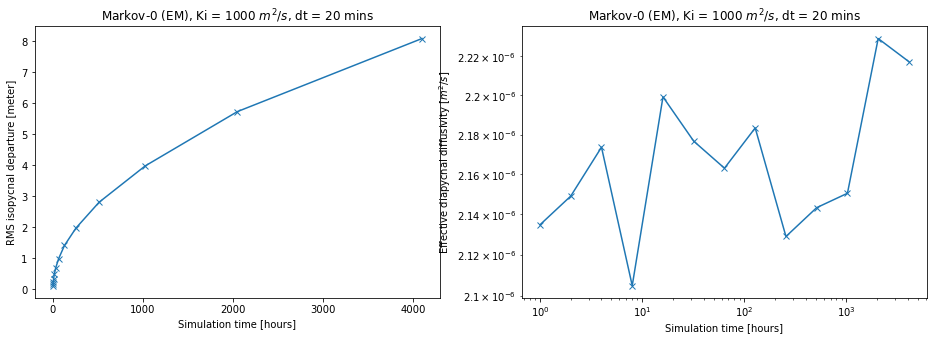

(array([0.12397819, 0.17591645, 0.25019895, 0.34819313, 0.50333344,
        0.70816847, 0.99836432, 1.4185169 , 1.98095121, 2.81089081,
        3.9818373 , 5.7332616 , 8.08630489]),
 <function __main__.diapycnal_flux(x, y, z, t, rho=1027.5, tmode='seconds')>)

In [155]:
EM_error(20, 1000, powers=12)

# Analytical Markov-1

In [72]:
# Epsilon is chosen to cancel dt. Eta is chosen so that the diapycnal diffusivity is approximately 10^-8
fieldset = create_analytical_fieldset(myField, Ki=1000, Tl = 20 * 24 * 60 * 60, epsilon=40 * 60 / (20 * 24 * 60 * 60), eta=1e-7)
add_dummy_settings(fieldset)
testParticles = get_test_particles_dense(myField, fieldset, rho=1027.5)
ParcelsRandom.seed(1636)
testParticles.execute(
            testParticles.Kernel(elements_analytical.elements_analytical) 
            + testParticles.Kernel(Markov1_3D_BC_taper_init.Markov1_3D_BC_taper_init),
            dt=0,
            verbose_progress=True,
)
testParticles.execute(
    testParticles.Kernel(elements_analytical.elements_analytical) 
    + testParticles.Kernel(Markov1_3D_BC_taper.Markov1_3D_BC_taper),
    runtime=timedelta(days=90),
    dt=timedelta(minutes=40),
    verbose_progress=True,
)
print(rms_z_error(testParticles.lon, testParticles.lat, testParticles.depth))
diapycnal_flux(testParticles.lon, testParticles.lat, testParticles.depth, 90*24*60*60)

INFO: Compiled Markov1Particleelements_analyticalMarkov1_3D_BC_taper_init ==> /tmp/parcels-23300/282bac45fa721731d35e561d0b752a03_0.so
| |#                                                  | 0 Elapsed Time: 0:00:00
INFO: Compiled Markov1Particleelements_analyticalMarkov1_3D_BC_taper ==> /tmp/parcels-23300/c0d00608a3a1e8e8628d25c2ec6d10d3_0.so
100% (7776000.0 of 7776000.0) |##########| Elapsed Time: 0:00:51 Time:  0:00:51


1.4705589923143432


1.390524530527634e-07

In [117]:
# # Create figure of initialized particles
# fig = go.Figure(data=[go.Surface(x=XX/1000, y=YY/1000, z=ZZ_iso1027, opacity=0.4, showscale=False),
#                       go.Scatter3d(x=(testParticles.lon % 1_000_000)/1000, y=(testParticles.lat % 2_000_000)/1000, z=testParticles.depth,
#                                    mode='markers', marker=dict(size=0.5, color='blue'), opacity=0.7)])
# fig.update_layout(
#     #title="Isopycnal",
#     autosize=False,
#     width=800,
#     height=500,
#     margin=dict(l=20, r=20, b=20, t=20),
#     scene=dict(
#         aspectratio=dict(x=1, y=2, z=0.5),
#         xaxis=dict(title="x [km]"),
#         yaxis=dict(title="y [km]"),
#         zaxis=dict(title="z [m]", nticks=3),
#     ),
#     scene_camera = dict(
#         eye=dict(x=1.25*1.8, y=-0.5*1.8, z=0.75*1.8)
#     )
# )
# fig.write_image("viz/particles_Markov1_90days_k1000_Tl20_dt40mins.png", width=800, height=500, scale=3)

In [118]:
def Markov1_error(dt_mins, Tl_days, Ki, powers=11, epsilon=0.01, eta=1e-5, pclass=Markov1Particle, plot=True):
    runHours = np.ones(powers) * 2**np.arange(powers)
    z_error = np.zeros(powers)
    diaflux = np.zeros(powers)
    
    if epsilon == 'dt-dependent':
        fieldset = create_analytical_fieldset(myField, Ki=Ki, Tl=Tl_days * 24 * 60 * 60, epsilon=dt_mins*60/(Tl_days*24*60*60), eta=eta)
    else:
        fieldset = create_analytical_fieldset(myField, Ki=Ki, Tl=Tl_days * 24 * 60 * 60, epsilon=epsilon, eta=eta)
    add_dummy_settings(fieldset)
    
    for i, hours in enumerate(runHours):
        testParticles = get_test_particles_dense(myField, fieldset, pclass=pclass)
        ParcelsRandom.seed(1636)
        testParticles.execute(
                    testParticles.Kernel(elements_analytical.elements_analytical) 
                    + testParticles.Kernel(Markov1_3D_BC_taper_init.Markov1_3D_BC_taper_init),
                    dt=0,
                    verbose_progress=True,
        )
        testParticles.execute(
            testParticles.Kernel(elements_analytical.elements_analytical) 
            + testParticles.Kernel(Markov1_3D_BC_taper.Markov1_3D_BC_taper),
            runtime=timedelta(hours=hours),
            dt=timedelta(minutes=dt_mins),
            verbose_progress=True,
        )
        
        z_error[i] = rms_z_error(testParticles.lon, testParticles.lat, testParticles.depth)
        diaflux[i] = diapycnal_flux(testParticles.lon, testParticles.lat, testParticles.depth, hours*60*60)
        
    if plot == True:
        fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
        ax[0].plot(runHours, z_error, '-x')
        ax[0].set_xlabel('Simulation time [hours]')
        ax[0].set_ylabel('RMS isopycnal departure [meter]')
        ax[0].set_title(fr"Markov-0 (EM), Ki = {Ki} $m^2/s$, dt = {dt_mins} mins")

        ax[1].loglog(runHours, diaflux, '-x')
        ax[1].set_ylabel(r"Effective diapycnal diffusivity [$m^2/s$]")
        ax[1].set_xlabel('Simulation time [hours]')
        ax[1].set_title(fr"Markov-0 (EM), Ki = {Ki} $m^2/s$, dt = {dt_mins} mins")

        plt.show()
    
    return z_error, diapycnal_flux

INFO: Compiled Markov1Particleelements_analyticalMarkov1_3D_BC_taper_init ==> /tmp/parcels-23300/1000dab716324dc649671a4d248d1a09_0.so
| |#                                                  | 0 Elapsed Time: 0:00:00
INFO: Compiled Markov1Particleelements_analyticalMarkov1_3D_BC_taper ==> /tmp/parcels-23300/96ed80960e6a740274165b7ea137d1c0_0.so
100% (3600.0 of 3600.0) |################| Elapsed Time: 0:00:00 Time:  0:00:00
INFO: Compiled Markov1Particleelements_analyticalMarkov1_3D_BC_taper_init ==> /tmp/parcels-23300/b344ac8ff270d55fc921ad04226aaa3f_0.so
| |#                                                  | 0 Elapsed Time: 0:00:00
INFO: Compiled Markov1Particleelements_analyticalMarkov1_3D_BC_taper ==> /tmp/parcels-23300/00f648270f048d4d7e8f449cf5e5685d_0.so
100% (7200.0 of 7200.0) |################| Elapsed Time: 0:00:00 Time:  0:00:00
INFO: Compiled Markov1Particleelements_analyticalMarkov1_3D_BC_taper_init ==> /tmp/parcels-23300/dc37bcd05af95a474b4013500bbfa3ec_0.so
| |#           

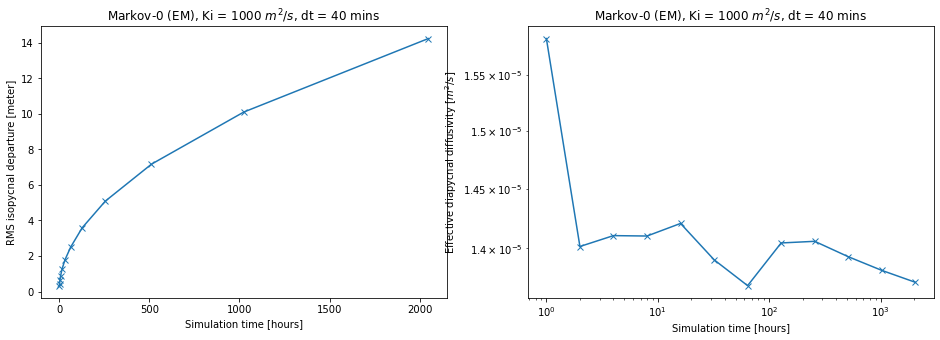

(array([ 0.33768197,  0.44923926,  0.63735634,  0.90124844,  1.27928015,
         1.789975  ,  2.51220865,  3.59766032,  5.09031564,  7.16631505,
        10.09404411, 14.22523727]),
 <function __main__.diapycnal_flux(x, y, z, t, rho=1027.5, tmode='seconds')>)

In [162]:
Markov1_error(40, 20, 1000, powers=12, epsilon='dt-dependent')

## Check for spurious particle accumulation

In [112]:
ds_hist = xr.open_dataset("/data/oceanparcels/output_data/data_Daan/project_diffusion/markov1_90d_dense_dt40_hist.nc")

Plot initial and final fields

In [113]:
testParticles = get_test_particles_dense(myField, fieldset, rho=1027.5)
fig = go.Figure(data=[go.Surface(x=XX/1000, y=YY/1000, z=ZZ_iso1027, opacity=0.4, showscale=False),
                      go.Scatter3d(x=(ds_hist.isel(obs=0).lon % 1_000_000)/1000, y=(ds_hist.isel(obs=0).lat % 2_000_000)/1000, z=ds_hist.isel(obs=0).z,
                                   mode='markers', marker=dict(size=0.1, color='blue'), opacity=0.7)])
fig.update_layout(
    #title="Isopycnal",
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=20, r=20, b=20, t=20),
    scene=dict(
        aspectratio=dict(x=1, y=2, z=0.5),
        xaxis=dict(title="x [km]"),
        yaxis=dict(title="y [km]"),
        zaxis=dict(title="z [m]", nticks=3),
    ),
    scene_camera = dict(
        eye=dict(x=1.25*1.8, y=-0.5*1.8, z=0.75*1.8)
    )
)
fig.write_image("viz/particles_dense_initialized.png", width=800, height=500, scale=3)

In [114]:
testParticles = get_test_particles_dense(myField, fieldset, rho=1027.5)
fig = go.Figure(data=[go.Surface(x=XX/1000, y=YY/1000, z=ZZ_iso1027, opacity=0.4, showscale=False),
                      go.Scatter3d(x=(ds_hist.isel(obs=-1).lon % 1_000_000)/1000, y=(ds_hist.isel(obs=-1).lat % 2_000_000)/1000, z=ds_hist.isel(obs=-1).z,
                                   mode='markers', marker=dict(size=0.1, color='blue'), opacity=0.7)])
fig.update_layout(
    #title="Isopycnal",
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=20, r=20, b=20, t=20),
    scene=dict(
        aspectratio=dict(x=1, y=2, z=0.5),
        xaxis=dict(title="x [km]"),
        yaxis=dict(title="y [km]"),
        zaxis=dict(title="z [m]", nticks=3),
    ),
    scene_camera = dict(
        eye=dict(x=1.25*1.8, y=-0.5*1.8, z=0.75*1.8)
    )
)
fig.write_image("viz/particles_Markov1_90days_k1000_Tl20_dt40mins_dense.png", width=800, height=500, scale=3)

Compute concentrations

In [115]:
def surfaceIntegral(field, xlim, ylim):
    def f(y, x):
        return np.sqrt((field.g/field.Nsquared * field.alphax * field.kappax * np.cos(field.kappax * x))**2 +\
                       (field.g/field.Nsquared * field.alphay * field.kappay * np.cos(field.kappay * y))**2 +1)
    return dblquad(f, xlim[0], xlim[1], lambda x: ylim[0], lambda x: ylim[1])

In [116]:
def normalizedHistogram(lons, lats, nbins, field, rho_iso, boundsx = (0, 1_000_000), boundsy = (0, 1_000_000)):
    areas = np.zeros(nbins) 
    bounds_arrx = np.linspace(boundsx[0], boundsx[1], nbins[0]+1)
    bounds_arry = np.linspace(boundsy[0], boundsy[1], nbins[1]+1)
    for i in range(nbins[0]):
        for j in range(nbins[1]):
            areas[i,j] = surfaceIntegral(field, (bounds_arrx[i], bounds_arrx[i+1]), (bounds_arry[j], bounds_arry[j+1]))[0]
    totalArea = np.sum(areas)
#     areaWeights = areas/totalArea
    hist, xedges, yedges = np.histogram2d(lons, 
                                          lats, 
                                          bins=[np.linspace(boundsx[0], boundsx[1], nbins[0]+1),
                                                np.linspace(boundsy[0], boundsy[1], nbins[1]+1)], 
                                         )
#     normedHist = hist/areaWeights
    return hist, bounds_arrx, bounds_arry, areas

In [117]:
histInit, boundsx, boundsy, areas = normalizedHistogram(ds_hist.isel(obs=0).lon % 1_000_000, 
                                                        ds_hist.isel(obs=0).lat % 1_000_000,
                                                        nbins=(20, 20), 
                                                        field=myField,
                                                        boundsx=(0, 1_000_000),
                                                        boundsy=(0, 1_000_000),
                                                        rho_iso=1027.5)

In [118]:
histFinal, boundsx, boundsy, areas = normalizedHistogram(ds_hist.isel(obs=1).lon % 1_000_000, 
                                                         ds_hist.isel(obs=1).lat % 1_000_000,
                                                         nbins=(20, 20), 
                                                         field=myField,
                                                         boundsx=(0, 1_000_000),
                                                         boundsy=(0, 1_000_000),
                                                         rho_iso=1027.5)

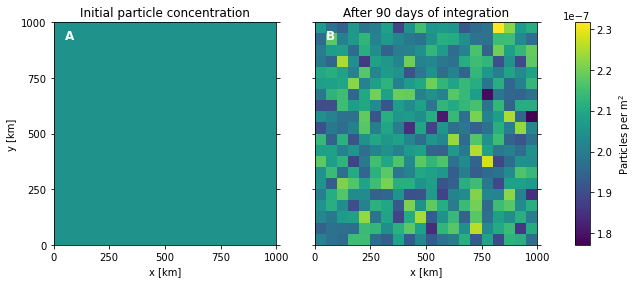

In [119]:
# fig, ax = plt.subplots(ncols=2, )
fig, (ax1, ax2, cax) = plt.subplots(ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[15, 15, 1]})
ax1.set_aspect(1)
ax2.set_aspect(1)

hist_init = ax1.pcolormesh(boundsx/1000, boundsy/1000, histInit/areas, shading='flat', vmin = (histFinal/areas).min(), vmax = (histFinal/areas).max())

ax1.set_xticks(np.arange(0, 1001, 250))
ax1.set_yticks(np.arange(0, 1001, 250))
ax1.tick_params(right=True, left=True)
ax1.set_xlabel("x [km]")
ax1.set_ylabel("y [km]")
ax1.set_title("Initial particle concentration")
ax1.text(0.05, 0.97, 'A', va='top', fontsize='large', weight='heavy', color='white', transform = ax1.transAxes)

hist_final = ax2.pcolormesh(boundsx/1000, boundsy/1000, histFinal/areas, shading='flat')

ax2.set_xticks(np.arange(0, 1001, 250))
ax2.set_yticks(np.arange(0, 1001, 250))
ax2.tick_params(right=True, left=True, labelleft=False)
ax2.set_xlabel("x [km]")
ax2.set_title("After 90 days of integration")
ax2.text(0.05, 0.97, 'B', va='top', fontsize='large', weight='heavy', color='white', transform = ax2.transAxes)

cbar = plt.colorbar(hist_final, cax=cax)
cbar.set_label(r"Particles per m$^{2}$")
plt.tight_layout()

plt.savefig("viz/histogram.pdf", bbox_inches='tight')

## Compare diapycnal errors after 90 days

In [75]:
dt_mins = np.array([10, 20, 40, 80, 160, 360, 720, 1440])

In [123]:
diapycnal_diffusivities = pd.read_csv("diapycnal_diffusivities_90d.csv")

In [124]:
diapycnal_diffusivities.rename(columns={
    'Unnamed: 0': 'dt', 
    'redi_smallslope': 'Markov-0 (small-slope)',
    'redi_full': 'Markov-0 (full)',
    'redi_full_M1' : 'Markov-0 (Milstein-1)',
    'markov-1' : 'Markov-1'
}, inplace=True)
diapycnal_diffusivities.set_index("dt", inplace=True)
pd.set_option('display.float_format', '{:.9g}'.format)
diapycnal_diffusivities

Markov-0 (full)  Markov-0 (small-slope)  Markov-0 (Milstein-1)  \
dt                                                                     
10     1.10872063e-06          1.10874552e-06         1.41723499e-10   
20      2.2074969e-06          2.20754639e-06         2.62185752e-10   
40     4.34344947e-06          4.34355074e-06          7.6923268e-10   
80     8.63105345e-06          8.63124583e-06         2.70925616e-09   
160    1.73507678e-05          1.73511692e-05         1.05980796e-08   
360    3.99651808e-05          3.99660965e-05          5.4055294e-08   
720    7.79130719e-05          7.79149003e-05         2.16713451e-07   
1440   0.000155702124          0.000155705803         8.52467962e-07   

           Markov-1  
dt                   
10   3.67327376e-09  
20   7.67567764e-09  
40    1.6639249e-08  
80   4.00413094e-08  
160  1.06360867e-07  
360  3.90317631e-07  
720  1.31613325e-06  
1440 4.08041054e-06

In [125]:
Tl = 20 * 24 * 60 * 60
nusq = 1000 / Tl
eta = 1e-8
eps = dt_mins * 60 / Tl
markov_dia_lowerbound = Tl*nusq*eta*eps

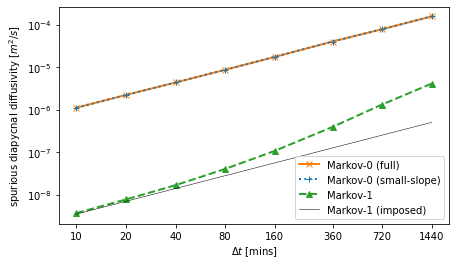

In [127]:
fig, ax = plt.subplots(figsize=(7,4))
# df.plot(ax=ax, color='black')
ax.plot(diapycnal_diffusivities.index, diapycnal_diffusivities["Markov-0 (full)"], color='C1', linewidth=2, linestyle='solid', marker='x', label="Markov-0 (full)")
ax.plot(diapycnal_diffusivities.index, diapycnal_diffusivities["Markov-0 (small-slope)"], color='C0', linewidth=2, linestyle=':', marker='+', label="Markov-0 (small-slope)")
ax.plot(diapycnal_diffusivities.index, diapycnal_diffusivities["Markov-1"], color='C2', linewidth=2, linestyle='--', marker='^', label="Markov-1")

ax.plot(diapycnal_diffusivities.index, markov_dia_lowerbound, linewidth=0.5, color='black', label="Markov-1 (imposed)")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(diapycnal_diffusivities.index)
for axis in [ax.xaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.legend()
plt.minorticks_off()
ax.set_xlabel(r'$\Delta t$ [mins]')
ax.set_ylabel(r'spurious diapycnal diffusivity [$m^2/s$]')
plt.savefig("viz/idealized_error_90d.pdf", bbox_inches='tight')